# HackTheCarbon - Monitoring Africa’s Forest Biomass from Space

<a href="https://colab.research.google.com/github/instadeepai/InstaGeo-E2E-Geospatial-ML/blob/main/notebooks/InstaGeo_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This starter notebook demonstrates the capabilities of [InstaGeo](https://github.com/instadeepai/InstaGeo-E2E-Geospatial-ML), an end-to-end framework for geospatial machine learning using multispectral satellite imagery.

The data provided in this hackathon comes from the European Space Agency’s (ESA) Climate Change Initiative (CCI) Biomass Project, which provides global above-ground biomass (AGB) measurements at a spatial resolution of 100 meters. The objective of this hackathon is to train a model that predicts AGB in Africa directly from Harmonized Landsat and Sentinel-2 (HLS) multispectral imagery at a finer resolution of 30 meters. To align the ground truth data with the HLS resolution, the original 100m biomass rasters were upsampled to 30m using cubic interpolation. This resampling step improves spatial alignment and enables pixel-wise training at higher resolution. The figure below illustrates the data split into training, validation, and test sets.

The notebook will walk you through the full workflow: generating satellite chip data, fine-tuning the [Prithvi](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M) geospatial foundation model, and visualizing inference results on an interactive map.

By the end of this demo, you’ll gain hands-on experience with key InstaGeo functionalities and learn how the framework streamlines geospatial ML workflows from data preparation to model inference.

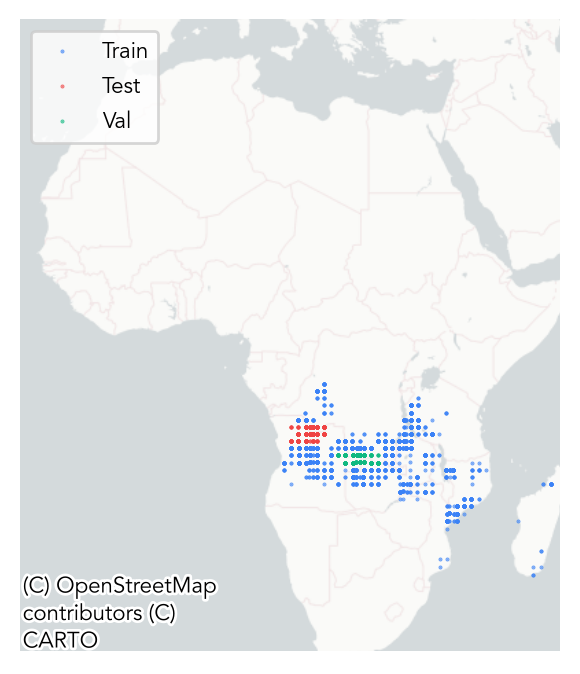

# Install InstaGeo

In [1]:
%%bash
repository_url="https://github.com/instadeepai/InstaGeo-E2E-Geospatial-ML"
git clone ${repository_url}

Cloning into 'InstaGeo-E2E-Geospatial-ML'...


In [2]:
%%bash
cd InstaGeo-E2E-Geospatial-ML
git checkout 4797f1590bf4c3a8fa4ca9ed2886f791cea512a4
pip install -e .[all]

Obtaining file:///kaggle/working/InstaGeo-E2E-Geospatial-ML
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of h5pyd to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is 

Note: switching to '4797f1590bf4c3a8fa4ca9ed2886f791cea512a4'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 4797f15 fix: fix bug in output_dir
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is inc

## InstaGeo - Data (Optional)

### EarthData Login

InstaGeo currently supports multispectral data from NASA [Harmonized Landsat and Sentinel-2 (HLS)](https://hls.gsfc.nasa.gov/). Accessing HLS data requires an EarthData user account which can be created [here](https://urs.earthdata.nasa.gov/)

In [3]:
# from getpass import getpass
# import os

In [4]:
# # Enter you EarthData user account credentials
# USERNAME = getpass('Enter your EarthData username: ')
# PASSWORD = getpass('Enter your EarthData password: ')

# content = f"""machine urs.earthdata.nasa.gov login {USERNAME} password {PASSWORD}"""

# with open(os.path.expanduser('~/.netrc'), 'w') as file:
#     file.write(content)

With InstaGeo installed and EarthData authentication configured, we are now ready to download and process HLS (Harmonized Landsat and Sentinel) granules using the `InstaGeo-Data` module. This module offers several powerful functionalities for handling geospatial data, including:

- Searching and retrieving metadata for HLS granules
- Downloading specific spectral bands from HLS granules
- Generating data chips and corresponding target labels for machine learning tasks

These capabilities streamline the preprocessing of multispectral data, setting the foundation for efficient geospatial model development.



In [5]:
# import pandas as pd
# import numpy as np
# from pathlib import Path

The ground-truth geospatial observations for Rwanda cropland classification used in this notebook were sourced from the [Rwanda 2019 Crop/Non-Crop Labels (HarvestPortal)](https://data.harvestportal.org/dataset/rwanda-2019-crop-non-crop-labels) dataset. Run the following cell to download the data.

In [6]:
# !wget -q --show-progress https://data.harvestportal.org/dataset/9f4b6470-2c7b-4559-95cb-49e9fd2923f6/resource/ed0ab379-a688-4419-ab96-181c726e1b22/download/ceo-2019-rwanda-cropland-sample-data-2021-04-20.csv
# !wget -q --show-progress https://data.harvestportal.org/dataset/9f4b6470-2c7b-4559-95cb-49e9fd2923f6/resource/0cfc1320-f909-4759-90f9-cb5c92ca019e/download/ceo-2019-rwanda-cropland-rcmrd-set-1-sample-data-2021-04-20.csv
# !wget -q --show-progress https://data.harvestportal.org/dataset/9f4b6470-2c7b-4559-95cb-49e9fd2923f6/resource/6675cc7e-e6da-4889-9905-60c0d5369ce6/download/ceo-2019-rwanda-cropland-rcmrd-set-2-sample-data-2021-04-20.csv

In [7]:
# df1 = pd.read_csv("ceo-2019-rwanda-cropland-sample-data-2021-04-20.csv")
# df2 = pd.read_csv("ceo-2019-rwanda-cropland-rcmrd-set-1-sample-data-2021-04-20.csv")
# df3 = pd.read_csv("ceo-2019-rwanda-cropland-rcmrd-set-2-sample-data-2021-04-20.csv")

# df = pd.concat([df1, df2, df3])

In [8]:
# df = df[['lat', 'lon', 'collection_time', 'Crop/ or not', 'sample_id']]
# df = df.rename({"lon": "x", "lat":"y", "Crop/ or not":'label', 'collection_time':"date"}, axis=1)
# df.head(10)

In [9]:
# def label_map(x):
#     if x == "Cropland":
#         return 1
#     elif x == "Non-crop":
#         return 0
#     else:
#         return np.nan

# df['date'] = df['date'].map(lambda x: pd.to_datetime(x).strftime("%Y-%m-%d"))
# df['label'] = df['label'].map(label_map)
# df = df.dropna().reset_index()
# df.head(10)

In [10]:
# print(f"The number of labeled observations in the aggregated dataset is: {df.shape[0]}")

**Optional**: For the sake of rapid experimentation, let's use a subset of the observations (for instance 10%), while keeping approximately the same distribution for the labels.

In [11]:
# df = df.groupby('label', as_index=False).sample(frac=0.1).reset_index(drop=True)
# print(f"The number of labeled observations in the subset is: {df.shape[0]}")

In [12]:
# from sklearn.model_selection import train_test_split

# train, val_and_test = train_test_split(df, test_size=0.3)
# val, test = train_test_split(val_and_test, test_size=0.5)

# print(train.size, val.size, test.size)

In [13]:
# train.to_csv("rwanda_cropland_data_train.csv")
# val.to_csv("rwanda_cropland_data_val.csv")
# test.to_csv("rwanda_cropland_data_test.csv")

After splitting the data into training, validation, and test sets, the next step is to group the data by the HLS granules they belong to and download the corresponding spectral bands for each granule. Once the bands are retrieved, we will generate smaller chips and target labels with dimensions of 256 x 256 pixels.

By the end of this process, the input data will have a shape of 3 x 6 x 256 x 256 (representing three sets of six spectral bands and 256 x 256 pixel chips), and the target labels will have a shape of 256 x 256.

While these tasks might seem complex, the `InstaGeo-Data` module abstracts this process, allowing you to configure it with a simple command as shown in the following cells

### Training Split

In [14]:
# %%bash
# mkdir train
# python -m "instageo.data.chip_creator" \
#     --dataframe_path="rwanda_cropland_data_train.csv" \
#     --output_directory="train" \
#     --min_count=3 \
#     --chip_size=256 \
#     --temporal_tolerance=3 \
#     --temporal_step=30 \
#     --num_steps=3 \
#     --masking_strategy=any \
#     --mask_types=water \
#     --window_size=1 \
#     --processing_method=cog

In [15]:
# root_dir = Path.cwd()
# chips_orig = os.listdir(os.path.join(root_dir, "train/chips"))
# chips = [chip.replace("chip", "train/chips/chip") for chip in chips_orig]
# seg_maps = [chip.replace("chip", "train/seg_maps/seg_map") for chip in chips_orig]

# df = pd.DataFrame({"Input": chips, "Label": seg_maps})
# df.to_csv(os.path.join("train.csv"))

In [16]:
# print(f"The size of the train split: {df.shape[0]}")

### Validation Split

In [17]:
# %%bash
# mkdir val
# python -m "instageo.data.chip_creator" \
#     --dataframe_path="rwanda_cropland_data_val.csv" \
#     --output_directory="val" \
#     --min_count=3 \
#     --chip_size=256 \
#     --temporal_tolerance=3 \
#     --temporal_step=30 \
#     --num_steps=3 \
#     --masking_strategy=any \
#     --mask_types=water \
#     --window_size=1 \
#     --processing_method=cog

In [18]:
# root_dir = Path.cwd()
# chips_orig = os.listdir(os.path.join(root_dir, "val/chips"))
# chips = [chip.replace("chip", "val/chips/chip") for chip in chips_orig]
# seg_maps = [chip.replace("chip", "val/seg_maps/seg_map") for chip in chips_orig]

# df = pd.DataFrame({"Input": chips, "Label": seg_maps})
# df.to_csv(os.path.join("val.csv"))

In [19]:
# print(f"The size of the validation split: {df.shape[0]}")

### Test Split

In [20]:
# %%bash
# mkdir test
# python -m "instageo.data.chip_creator" \
#     --dataframe_path="rwanda_cropland_data_test.csv" \
#     --output_directory="test" \
#     --min_count=3 \
#     --chip_size=256 \
#     --temporal_tolerance=3 \
#     --temporal_step=30 \
#     --num_steps=3 \
#     --masking_strategy=any \
#     --mask_types=water \
#     --window_size=1 \
#     --processing_method=cog

In [21]:
# root_dir = Path.cwd()
# chips_orig = os.listdir(os.path.join(root_dir, "test/chips"))
# chips = [chip.replace("chip", "test/chips/chip") for chip in chips_orig]
# seg_maps = [chip.replace("chip", "test/seg_maps/seg_map") for chip in chips_orig]

# df = pd.DataFrame({"Input": chips, "Label": seg_maps})
# df.to_csv(os.path.join("test.csv"))

In [22]:
# print(f"The size of the test split: {df.shape[0]}")

## InstaGeo - Model

After creating our dataset using the `InstaGeo-Data` module, we can move on to fine-tuning a model that includes a Prithvi backbone paired with a classification head. For regression tasks, the classification head can easily be replaced with a suitable regression head.

For this hackathon, the dataset has already been created and only needs to be loaded from `/kaggle/input/hack-the-carbon` directory.

In [23]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

**Launch Training**

First compute the mean and standard deviation for the dataset and update the corresponding config file, in this case `locust.yaml`

In [24]:
# !python -m instageo.model.run --config-name=biomass \
#     root_dir='/kaggle/input/hack-the-carbon/' \
#     train.batch_size=12 \
#     dataloader.img_size=256 \
#     mode=stats \
#     train_filepath='/kaggle/input/hack-the-carbon/train.csv'

#### Run training

In [25]:
!python -m instageo.model.run --config-name=biomass \
    hydra.run.dir="biomass_exp" \
    root_dir='/kaggle/input/hack-the-carbon' \
    train.batch_size=8 \
    train.num_epochs=10 \
    train.weight_decay=0.05 \
    train.learning_rate=0.002 \
    train.log_transform=False \
    mode=train \
    train_filepath="/kaggle/input/hack-the-carbon/train.csv" \
    valid_filepath="/kaggle/input/hack-the-carbon/val.csv"

[2025-08-15 18:25:12,161][absl][INFO] - Download successful on attempt 1
[2025-08-15 18:25:12,480][absl][INFO] - Download successful on attempt 1
[2025-08-15 18:25:14,588][root][INFO] - GPU is available. Using GPU...
[2025-08-15 18:25:14,630][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: True
[2025-08-15 18:25:14,630][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2025-08-15 18:25:14,631][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2025-08-15 18:25:14,720][lightning_fabric.utilities.distributed][INFO] - Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
[2025-08-15 18:25:31,627][absl][INFO] - File '/root/.instageo/prithvi/Prithvi_EO_V1_100M.pt' already exists. Skipping download.
[2025-08-15 18:25:31,627][absl][INFO] - File '/root/.instageo/prithvi/config.yaml' already exists. Skipping download.
[2025-08-15 18:25:33,838][root][INFO] - GPU is available. Using GPU...
[20

**Run Model Evaluation**

The general public leaderboard would use the downsampled evaluation. Then for the final winners, the first 10 on the oublic leaderboard would submit their model checkpoints which would be used to run the full evaluation

Adjust the `checkpoint_path` argument to use the desired model checkpoint.

In [26]:
!python -m instageo.model.run --config-path $(pwd)/biomass_exp/.hydra --config-name=config \
    hydra.run.dir="biomass_exp" \
    root_dir='/kaggle/input/hack-the-carbon' \
    test_filepath="/kaggle/input/hack-the-carbon/val.csv" \
    train.batch_size=32 \
    checkpoint_path='biomass_exp/instageo_best_checkpoint.ckpt' \
    mode=eval

[2025-08-15 19:55:50,504][absl][INFO] - File '/root/.instageo/prithvi/Prithvi_EO_V1_100M.pt' already exists. Skipping download.
[2025-08-15 19:55:50,504][absl][INFO] - File '/root/.instageo/prithvi/config.yaml' already exists. Skipping download.
[2025-08-15 19:55:52,604][root][INFO] - GPU is available. Using GPU...
[2025-08-15 19:55:52,608][pytorch_lightning.utilities.rank_zero][INFO] - 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
[2025-08-15 19:55:52,645][pytorch_lightning.utilities.rank_zero][INFO] - GPU available: True (cuda), used: True
[2025-08-15 19:55:52,646][pytorch_lightning.utilities.rank_zero][INFO] - TPU available: False, using: 0 TPU cores
[2025-08-15 19:55:52,646][pytorch_lightning.utilities.rank_zero][INFO] - HPU available: False, using: 0 HPUs
[2025-08-15 19:55:52,650][lightning_fabric.utilities.distributed][INFO

**Run Inference**

We'll use the chips from the test split to generate predictions.

In [27]:
!python -m instageo.model.run --config-path $(pwd)/biomass_exp/.hydra --config-name=config \
    hydra.run.dir="biomass_exp" \
    root_dir='/kaggle/input/hack-the-carbon' \
    output_dir='predictions' \
    test_filepath="/kaggle/input/hack-the-carbon/test.csv" \
    train.batch_size=32 \
    checkpoint_path='biomass_exp/instageo_best_checkpoint.ckpt' \
    mode=chip_inference

[2025-08-15 19:57:03,694][absl][INFO] - File '/root/.instageo/prithvi/Prithvi_EO_V1_100M.pt' already exists. Skipping download.
[2025-08-15 19:57:03,695][absl][INFO] - File '/root/.instageo/prithvi/config.yaml' already exists. Skipping download.
[2025-08-15 19:57:05,822][root][INFO] - GPU is available. Using GPU...
Running Inference: 100%|████████████████████████| 30/30 [01:43<00:00,  3.44s/it]


In [28]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import os
import rasterio
from glob import glob
from tqdm import tqdm

def read_seg_map(seg_map_filename):
  with rasterio.open(seg_map_filename) as dataset:
    image_array = dataset.read()
  return image_array

def downsample_seg_map(input_array, sample_id, ignore_idx=None, kernel_size=4, stride=4):
    if input_array.ndim != 2:
        raise ValueError("Input array must be 2D")

    H, W = input_array.shape
    out_H = (H - kernel_size) // stride + 1
    out_W = (W - kernel_size) // stride + 1

    output = np.zeros((out_H, out_W))
    sample_ids = []
    values = []
    for i in range(out_H):
        for j in range(out_W):
            start_h = i * stride
            end_h = start_h + kernel_size
            start_w = j * stride
            end_w = start_w + kernel_size
            patch = input_array[start_h:end_h, start_w:end_w]
            if ignore_idx is not None:
                patch = np.where(patch == ignore_idx, np.nan, patch)
            if np.any(np.isnan(patch)):
                continue
            else:
                value_at_idx = np.nanmean(patch)
            sample_ids.append(f"{sample_id}_{i}_{j}")
            values.append(np.round(value_at_idx, 0).astype(np.int16) if value_at_idx is not np.nan else np.nan)
    return sample_ids, values


def generate_submission_csv(data_path, ignore_idx=None, output_directory="."):
  prediction_tif_files = glob(os.path.join(data_path, "*.tif"))
  final_sample_ids = []
  final_values = []
  for tif_file in tqdm(prediction_tif_files):
    seg_map = read_seg_map(tif_file).squeeze(0)
    sample_id = os.path.splitext(os.path.basename(tif_file))[0].removeprefix("label_").removeprefix("prediction_")
    sample_ids, values= downsample_seg_map(seg_map, sample_id, ignore_idx=ignore_idx)
    final_sample_ids.extend(sample_ids)
    final_values.extend(values)
  submission_df=pd.DataFrame({'ID':final_sample_ids, 'prediction':final_values}).dropna()
  submission_df.to_csv(os.path.join(output_directory, 'submission.csv'), index=False)
  return submission_df

df = generate_submission_csv("predictions")

100%|██████████| 947/947 [02:40<00:00,  5.90it/s]


## InstaGeo - Apps
Once inference has been completed and the prediction GeoTiffs have been saved, we can use the `InstaGeo-Apps` module to visualize the predictions on an interactive map.

To visualize the results, simply provide the path to predictions directory and `InstaGeo-Apps` will handle the rest, providing an intuitive and interactive mapping experience.

In [29]:
# !npm install localtunnel

In [30]:
# !nohup streamlit run InstaGeo-E2E-Geospatial-ML/instageo/apps/app.py --server.address=localhost &

In [31]:
# !nohup streamlit run /app/instageo/apps/app.py --server.address=localhost

Retrieve your IP address which is the password of the localtunnel

In [32]:
# import urllib
# print("Password/Endpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

## Summary

In this notebook, we demonstrated the end-to-end capabilities of InstaGeo for geospatial machine learning using multispectral data. We began by downloading and processing HLS granules, creating data chips for training, and fine-tuning a model with the Prithvi backbone. Finally, we ran inference on test data and visualized the results using the `InstaGeo-Apps` module.

By leveraging InstaGeo, complex tasks such as data preprocessing, model training, and large-scale inference can be streamlined and efficiently handled with minimal configuration.

If you found this demo helpful, please consider giving our [InstaGeo GitHub repository](https://github.com/instadeepai/InstaGeo-E2E-Geospatial-ML) a star ⭐! Your support helps us continue improving the tool for the community.

Thank you for exploring InstaGeo with us!